In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve,f1_score, fbeta_score, classification_report

from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import json

## A Minimum Viable Product

For a baseline, I constructed a logistic regression model with no regularization. I also tried out a K Nearest Neighbors model and a Naive Bayes model, though I expected due to class imbalances that these would not prove optimal. 

In [3]:
covid_clean = pd.read_json('covid_no_nan.json', lines=True)

In [4]:
covid_clean.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,passed
0,033f0a,1,0,2020-06-24T00:00:00.000Z,2020-06-19T00:00:00.000Z,9999-99-99,0,0,46,0,...,0,0,0,0,0,0,0,1,0,0
1,18be58,1,1,2020-06-19T00:00:00.000Z,2020-06-19T00:00:00.000Z,9999-99-99,0,1,57,0,...,1,0,0,0,1,1,1,1,0,0
2,1e7e67,0,0,2020-06-08T00:00:00.000Z,2020-06-01T00:00:00.000Z,9999-99-99,0,0,65,0,...,1,0,0,0,0,0,0,1,0,0
3,003bcb,1,0,2020-06-08T00:00:00.000Z,2020-06-05T00:00:00.000Z,9999-99-99,0,0,39,0,...,0,0,0,0,0,0,1,1,0,0
4,1a8351,1,0,2020-06-08T00:00:00.000Z,2020-06-02T00:00:00.000Z,9999-99-99,0,0,45,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
covid_clean.shape

(561096, 24)

In [6]:
categoricals = [ 'sex','patient_type', 'pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr',
       'hypertension', 'other_disease', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco', 'pregnancy', 'icu', 'intubed', 'covid_res',
       'contact_other_covid', 'passed']

In [7]:
covid_clean[categoricals] = covid_clean[categoricals].astype('category')

In [8]:
covid_clean.dtypes

id                       object
sex                    category
patient_type           category
entry_date               object
date_symptoms            object
date_died                object
intubed                category
pneumonia              category
age                       int64
pregnancy              category
diabetes               category
copd                   category
asthma                 category
inmsupr                category
hypertension           category
other_disease          category
cardiovascular         category
obesity                category
renal_chronic          category
tobacco                category
contact_other_covid    category
covid_res              category
icu                    category
passed                 category
dtype: object

In [9]:
covid_clean['inmsupr'].value_counts()

0    552226
1      8870
Name: inmsupr, dtype: int64

In [10]:
# train / test split
df_train, df_test = train_test_split(covid_clean, test_size=0.2, random_state=33, stratify=covid_clean['passed'].values)

In [11]:
# train / validation split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=33, stratify=df_train['passed'].values)

In [12]:
df_train.columns

Index(['id', 'sex', 'patient_type', 'entry_date', 'date_symptoms', 'date_died',
       'intubed', 'pneumonia', 'age', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu', 'passed'],
      dtype='object')

### Logistic Regression - A Baseline

In [16]:
lm_1 = LogisticRegression(C=100000,
                         max_iter=5000)  # no regularization
features = ['age', 'sex', 'patient_type', 'cardiovascular', 'hypertension', 'obesity', 'inmsupr','copd', 'other_disease', 'renal_chronic','tobacco', 'covid_res']
X_train  = df_train[features]
y_train = df_train['passed']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

lm_1.fit(X_train, y_train)

LogisticRegression(C=100000, max_iter=5000)

In [17]:
print('intercept: ', lm_1.intercept_[0])
print('coefs: ', lm_1.coef_)

intercept:  -4.2359663750958605
coefs:  [[ 0.66590232  0.20633351  1.30744541 -0.01987385  0.05722235  0.10866261
   0.02250625 -0.01110812  0.04030872  0.05858481 -0.03319011  0.1553724 ]]


In [18]:
# scoring on training set
print(classification_report(y_train, lm_1.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97    336378
           1       0.43      0.09      0.15     22722

    accuracy                           0.93    359100
   macro avg       0.68      0.54      0.56    359100
weighted avg       0.91      0.93      0.91    359100



In [20]:
X_val = scaler.transform(df_val[features])
y_val = df_val['passed']
lr_preds = lm_1.predict(X_val)
lr_conf = confusion_matrix(y_val,
                lr_preds)
lr_conf

array([[83398,   698],
       [ 5159,   521]])

In [21]:
# scoring on validation set
print(classification_report(y_val, lm_1.predict(X_val)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84096
           1       0.43      0.09      0.15      5680

    accuracy                           0.93     89776
   macro avg       0.68      0.54      0.56     89776
weighted avg       0.91      0.93      0.91     89776



In [22]:
for feature, coef in zip(df_train[features], lm_1.coef_.T):
    print(feature, coef)

age [0.66590232]
sex [0.20633351]
patient_type [1.30744541]
cardiovascular [-0.01987385]
hypertension [0.05722235]
obesity [0.10866261]
inmsupr [0.02250625]
copd [-0.01110812]
other_disease [0.04030872]
renal_chronic [0.05858481]
tobacco [-0.03319011]
covid_res [0.1553724]


In [23]:
# this cell added at the end of the project
# scoring on test set
X_test  = df_test[features]
y_test = df_test['passed']
print(classification_report(y_test, lm_1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.02      0.03    105119
           1       0.06      0.99      0.12      7101

    accuracy                           0.08    112220
   macro avg       0.52      0.50      0.08    112220
weighted avg       0.91      0.08      0.04    112220



### Interpreting Coefficients with Respect to Log Loss

In [69]:
np.exp(1.307)

3.695071852189992

In [70]:
np.exp(0.662)

1.938665791236518

In [71]:
np.exp(0.15)

1.161834242728283

In [72]:
np.exp(0.02158273)

1.0218173217877218

In [73]:
np.exp(0.05466973)

1.056191728623155

In [81]:
np.exp(-0.01986256)

0.9803334010706944

In [54]:
sum(covid_clean['patient_type'])/len(covid_clean)

0.21391348361064774

In [55]:
sum(covid_clean['passed'])/len(covid_clean)

0.06327437729016068

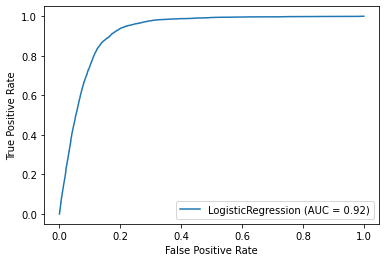

In [82]:
plot_roc_curve(lm_1, X_val, y_val);

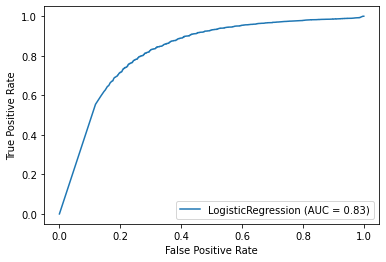

In [83]:
# this cell added at the end of the project
plot_roc_curve(lm_1, X_test, y_test);

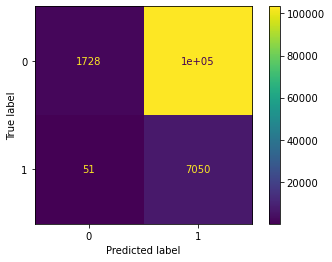

In [59]:
# this cell added at the end of the project
plot_confusion_matrix(lm_1, X_test, y_test);

In [52]:
lm_1.predict_proba(X_val)[:25]

array([[0.93642845, 0.06357155],
       [0.99640882, 0.00359118],
       [0.99618407, 0.00381593],
       [0.99052076, 0.00947924],
       [0.9897454 , 0.0102546 ],
       [0.99470976, 0.00529024],
       [0.99618407, 0.00381593],
       [0.9927463 , 0.0072537 ],
       [0.9951626 , 0.0048374 ],
       [0.99579331, 0.00420669],
       [0.98796466, 0.01203534],
       [0.99259478, 0.00740522],
       [0.41627985, 0.58372015],
       [0.99373477, 0.00626523],
       [0.99603013, 0.00396987],
       [0.63754327, 0.36245673],
       [0.57433044, 0.42566956],
       [0.98409429, 0.01590571],
       [0.99362266, 0.00637734],
       [0.99721959, 0.00278041],
       [0.9847018 , 0.0152982 ],
       [0.99721959, 0.00278041],
       [0.99633206, 0.00366794],
       [0.97359935, 0.02640065],
       [0.989663  , 0.010337  ]])

The first column of this array represents the probability that y=0, or that the person is still living, and the second column represents the probability that y=1, or the person has passed away.

### K Nearest Neighbors

In [25]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [26]:
print("The score for KNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_val, y_val)))

The score for KNN is
Training:  93.74%
Test set:  93.07%


In [59]:
# cursory comparison only

print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lm_1.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lm_1.score(X_val, y_val)))

The score for logistic regression is
Training:  93.46%
Test set:  93.54%


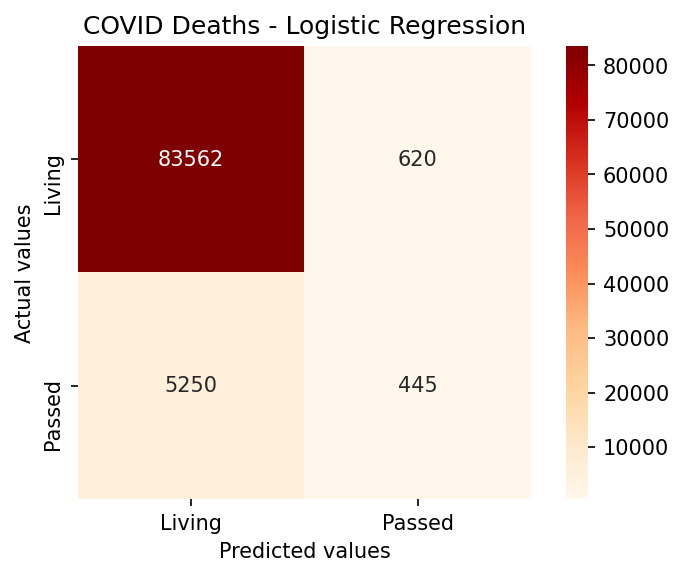

In [60]:
plt.figure(dpi=150)
sns.heatmap(lr_conf, cmap=plt.cm.OrRd, annot=True, fmt='d', square=True,
           xticklabels=['Living', 'Passed'],
           yticklabels=['Living', 'Passed'])

plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('COVID Deaths - Logistic Regression')
plt.savefig('COVID_regrconf_matrix', dpi=600, bbox_inches='tight');

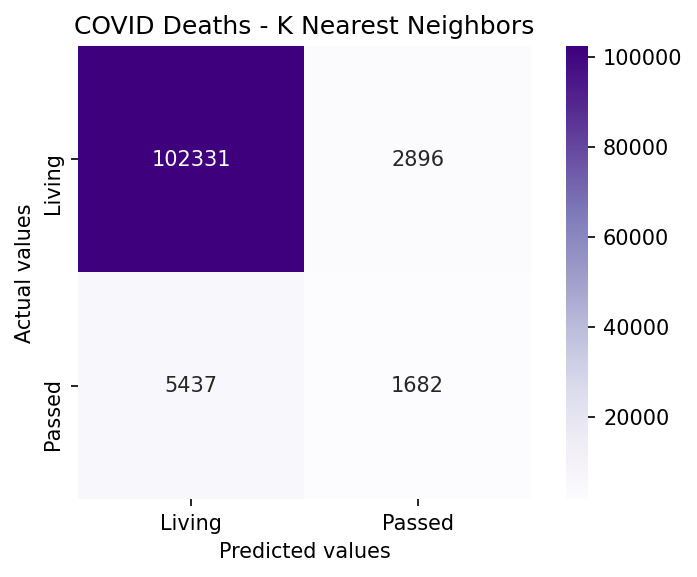

In [62]:
# cell added at end of project

knn_confusion = confusion_matrix(y_test, knn.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Purples, annot=True, fmt='d', square=True,
           xticklabels=['Living', 'Passed'],
           yticklabels=['Living', 'Passed'])

plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('COVID Deaths - K Nearest Neighbors')
plt.savefig('COVID_KNN_conf_matrix', dpi=600, bbox_inches='tight');

In [29]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier


In [30]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
nb.score(X_val, y_val)

0.9146120022074662

In [31]:
dc = DummyClassifier() # not for real problems, just a baseline 
dc.fit(X_train, y_train)
dc.score(X_val, y_val)

/Users/jess/workspace/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


0.8802449575418796

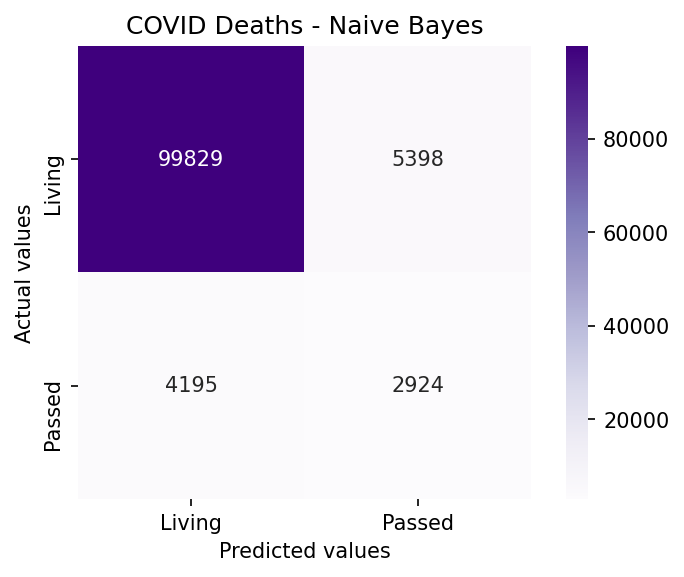

In [32]:
# cell added at end of project

NB_confusion = confusion_matrix(y_test, nb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(NB_confusion, cmap=plt.cm.Purples, annot=True, fmt='d', square=True,
           xticklabels=['Living', 'Passed'],
           yticklabels=['Living', 'Passed'])

plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('COVID Deaths - Naive Bayes')
plt.savefig('COVID_NB_conf_matrix', dpi=600, bbox_inches='tight');

In [12]:
print(classification_report(y_val, lr_preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     84182
           1       0.42      0.08      0.13      5695

    accuracy                           0.93     89877
   macro avg       0.68      0.54      0.55     89877
weighted avg       0.91      0.93      0.91     89877



In [27]:
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97    105248
           1       0.42      0.08      0.14      7098

    accuracy                           0.93    112346
   macro avg       0.68      0.54      0.55    112346
weighted avg       0.91      0.93      0.91    112346



In [45]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96    105248
           1       0.35      0.16      0.22      7098

    accuracy                           0.93    112346
   macro avg       0.65      0.57      0.59    112346
weighted avg       0.91      0.93      0.92    112346



In [33]:
print(classification_report(y_test, nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95    105227
           1       0.35      0.41      0.38      7119

    accuracy                           0.91    112346
   macro avg       0.66      0.68      0.67    112346
weighted avg       0.92      0.91      0.92    112346



In [ ]:
import pickle
import os

models = ['lm_1', 'nb', 'knn']

if not os.path.exists('models'):
    os.makedirs('models')
    
for model_name in models:
    curr_model = eval(model_name)
    
    curr_model.fit()
    with open(f'models/{model_name}.pickle', 'wb') as pfile:
        pickle.dump(curr_)